# 01 INTRO: Árboles de Decisión
Explicación de cómo construír árboles de decisión.

Notebook original por [Javier Blanco Cordero](https://www.linkedin.com/in/javier-blanco-cordero-71373656/).

## 0101 Qué es un árbol de decisión?
Un tipo de algoritmo de aprendizaje supervisado que se basa en realizar particiones a partir de distintos niveles de las variables disponibles.

## 0102 Import
Importamos todas las librerías necesarias para este análisis ([¿No sabes lo que es una librería de Python?](https://www.quora.com/What-is-a-Python-library-and-what-can-I-use-it-for)): pandas, numpy, seaborn, matplotlib.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## 0103 Carga el dataset de coches de segunda mano
Para probar a hacer árboles de decisión sin overfitting utilizaremos un dataset sobre el precio de distintos coches de segunda mano que he encontrado en Kaggle ([aquí](https://www.kaggle.com/harturo123/online-adds-of-used-cars)).

Podéis encontrar el archivo listo para importar en mi github: 'https://raw.githubusercontent.com/astrojuanlu/the-valley-mds-arboles/main/data/coches_usados_esp.csv'.

Importa este dataset en un dataframe llamado **df**.

In [ ]:
# Url archivo raw
url = "https://raw.githubusercontent.com/astrojuanlu/the-valley-mds-arboles/main/data/coches_usados_esp.csv"

# Importa csv
df = pd.read_csv(url, sep=";")

# Visualización primeras filas
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


# 02 EDA
Realizaremos un pequeño análisis exploratorio visual para familiarizarnos con el dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93991 entries, 0 to 93990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          93991 non-null  int64  
 1   make        93991 non-null  object 
 2   model       93991 non-null  object 
 3   version     93991 non-null  object 
 4   months_old  93717 non-null  float64
 5   power       93504 non-null  float64
 6   sale_type   93979 non-null  object 
 7   num_owners  22660 non-null  float64
 8   gear_type   92710 non-null  object 
 9   fuel_type   93926 non-null  object 
 10  kms         93127 non-null  float64
 11  price       93991 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 8.6+ MB


In [ ]:
df.isna().sum()

ID                0
make              0
model             0
version           0
months_old      274
power           487
sale_type        12
num_owners    71331
gear_type      1281
fuel_type        65
kms             864
price             0
dtype: int64

In [ ]:
df.describe()

,ID,months_old,power,num_owners,kms,price
count,93991.00000,93717.000000,93504.000000,22660.000000,93127.000000,93991.000000
mean,55100.87935,63.094775,99.729477,1.055119,82702.565250,16587.291379
std,33119.32602,56.837686,42.698809,0.277124,75186.697789,15563.712383
min,25.00000,1.000000,0.000000,1.000000,0.000000,200.000000
25%,25452.50000,16.000000,77.000000,1.000000,18300.000000,8500.000000
50%,53896.00000,46.000000,88.000000,1.000000,66000.000000,13490.000000
75%,83573.50000,96.000000,110.000000,1.000000,129000.000000,19999.000000
max,113143.00000,374.000000,809.000000,11.000000,497000.000000,999999.000000


<ipython-input-6-f892f660266b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(np.round(df.corr(), 2), vmin=-1, vmax=1, annot=True, cmap="coolwarm")


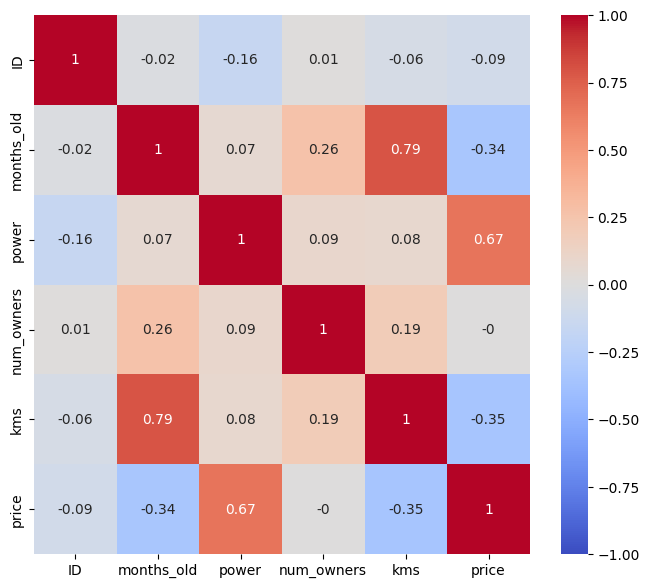

In [ ]:
# Visualización coeficientes Pearson
plt.figure(figsize=(8, 7))
sns.heatmap(np.round(df.corr(), 2), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

# 03 EJEMPLO
Vamos a ver paso a paso cómo realizar un modelo que prediga el precio sin caer en overfitting.

## 0301 Preparamos los datos
El dataframe tiene algunos nulos, así como variables categóricas y presencia de ciertas variables que probablemente no queramos usar.

### 030101 Variables Útiles
De entre las variables disponibles, veamos cuáles queremos utilizar como predictoras para el estudio.

In [ ]:
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


In [ ]:
df.columns

Index(['ID', 'make', 'model', 'version', 'months_old', 'power', 'sale_type',
       'num_owners', 'gear_type', 'fuel_type', 'kms', 'price'],
      dtype='object')

In [ ]:
cols = [
    "make",
    "model",
    "months_old",
    "power",
    "sale_type",
    "num_owners",
    "gear_type",
    "fuel_type",
    "kms",
    "price",
]

### 030102 Dumificación de variables categóricas

In [ ]:
df_i = pd.get_dummies(
    df[cols],
    prefix_sep="_",
    drop_first=True,
    columns=["make", "model", "sale_type", "gear_type", "fuel_type"],
)

display(len(df_i))
df_i.head()

93991

,months_old,power,num_owners,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,...,sale_type_new,sale_type_used,gear_type_manual,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid
0,240.0,210.0,3.0,202000.0,999999,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,54.0,487.0,1.0,30000.0,685000,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,358.0,220.0,NaN,56300.0,555555,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,14.0,368.0,1.0,2800.0,470000,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,3.0,515.0,NaN,10.0,450000,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### 030103 Limpieza de nulos
Con la dumificación hemos eliminado los nulos en las columnas categóricas sin deshacernos de las filas. Queda algún nulo en las variables numéricas?


In [ ]:
df_i.columns

Index(['months_old', 'power', 'num_owners', 'kms', 'price', 'make_Audi',
       'make_Bentley', 'make_Bmw', 'make_Chevrolet', 'make_Chrysler',
       ...
       'sale_type_new', 'sale_type_used', 'gear_type_manual',
       'gear_type_semi-automatic', 'fuel_type_LPG', 'fuel_type_diesel',
       'fuel_type_electric', 'fuel_type_etanol', 'fuel_type_gasoline',
       'fuel_type_hybrid'],
      dtype='object', length=299)

In [ ]:
df_i[["months_old", "power", "num_owners", "kms", "price"]].isna().sum()

months_old      274
power           487
num_owners    71331
kms             864
price             0
dtype: int64

In [ ]:
# Hay muchos nulos en num_owners
# Quizás esto tiene que ver con origenes del coche desconocidos?
# Vamos a limpiar la variable en 1, 2, 3+, nulo y la utilizamos como categórica
filtro_muchos_owners = df_i["num_owners"] >= 3
df_i.loc[filtro_muchos_owners, "num_owners"] = "3+"
df_i = pd.get_dummies(
    df_i, prefix_sep="_", dummy_na=True, drop_first=True, columns=["num_owners"]
)
df_i.head()

,months_old,power,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,make_Citroen,...,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid,num_owners_2.0,num_owners_3+,num_owners_nan
0,240.0,210.0,202000.0,999999,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,54.0,487.0,30000.0,685000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,358.0,220.0,56300.0,555555,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,14.0,368.0,2800.0,470000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3.0,515.0,10.0,450000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
df_i[["months_old", "power", "kms", "price"]].isna().sum()

months_old    274
power         487
kms           864
price           0
dtype: int64

In [ ]:
for col in ["months_old", "power", "kms"]:
    df_i[col] = df_i[col].fillna(df_i[col].median())

In [ ]:
df_i.isna().sum()

months_old            0
power                 0
kms                   0
price                 0
make_Audi             0
                     ..
fuel_type_gasoline    0
fuel_type_hybrid      0
num_owners_2.0        0
num_owners_3+         0
num_owners_nan        0
Length: 301, dtype: int64

##0302 Train - test split
Separamos el set de datos en dos utilizando [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


In [ ]:
X = df_i.drop("price", axis=1)
y = df_i["price"]

len(X), len(y)

(93991, 93991)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

## 0303 Entrenamos el árbol de decisión
Sobre el set de entrenamiento, comprobamos el modelo sobre el set de test.
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 4212.870964705138
RMSE en set de test : 5609.108065606621


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=5)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 7140.0614444012435
RMSE en set de test : 7299.206539578955


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=50)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 375.8288396572212
RMSE en set de test : 5553.874038556935


In [ ]:
def entrenar_modelo_y_predecir(modelo):
    # Entreno el árbol con el set de entrenamiento
    modelo = modelo.fit(X=X_train, y=y_train)
    # Uso el árbol para predecir sobre el dataset de entrenamiento
    y_pred_train = modelo.predict(X_train)
    # Uso el árbol para predecir sobre el dataset de test
    y_pred_test = modelo.predict(X_test)
    # Cómo de buena es la predicción?
    print(
        "RMSE en set de entrenamiento :",
        mean_squared_error(y_train, y_pred_train, squared=False),
    )
    print(
        "RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False)
    )

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 1126.6387046421803
RMSE en set de test : 5703.693208934427


## 0304 Probamos medidas contra el overfitting

### 030401 min_samples_split
Tamaño muestral mínimo para permitir una partición.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5767.079011141262
RMSE en set de test : 5805.837721035322


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5157.930973566498
RMSE en set de test : 5543.631368902679


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5233.351078575653
RMSE en set de test : 5516.37477747711


### 030402 min_samples_leaf
Tamaño muestral mínimo en una hoja.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=15, min_samples_split=25, min_samples_leaf=10
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 6399.317094587207
RMSE en set de test : 5866.765746205118


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=20, min_samples_split=20, min_samples_leaf=2
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5467.303845297351
RMSE en set de test : 5779.442210342198


### 030402 min_impurity_decrease
Mínimo descenso de impuridad.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=15, min_samples_split=25, min_impurity_decrease=0.25
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5233.351078575653
RMSE en set de test : 5524.621700797551


# 06 EJERCICIO TITANIC
Recordais el dataset del Titanic?

Vamos a resolver este problema teniendo en cuenta todo lo que sabemos ya. El objetivo es crear una árbol de decisión que prediga si un pasajero falleció o no (pasajeros cuyos datos no conocemos todavía).

Toma las medidas oportunas para que tu modelo sea lo más preciso posible sin caer en overfitting.

## 0601 Importa el dataset
Puedes encontrarlo en mi github. Este es el link al archivo raw: https://raw.githubusercontent.com/astrojuanlu/the-valley-mds-arboles/main/data/titanic.csv.

Importa los datos en un dataframe llamado dataframe **df_titanic**.

In [ ]:
# Url archivo raw
url = "https://raw.githubusercontent.com/astrojuanlu/the-valley-mds-arboles/main/data/titanic.csv"

# Importa csv
df_titanic = pd.read_csv(url)

# Visualización primeras filas
df_titanic.head(2)

HTTPError: ignored

## 0602 Prepara los datos
Quédate con las variables interesantes, dumifica las categóricas y limpia los nulos.

In [ ]:
# Creamos una nueva variable Título (esto es opcional, pero podría ayudar al modelo)
df_titanic["Title"] = [
    name.split(",")[1].split(".")[0][1:] for name in df_titanic["Name"]
]

In [ ]:
df_titanic.columns

In [ ]:
# Descartamos ciertas columnas con oel nombre, o la cabina
# Tienen muchas posibles categorías, pero deberían ser buenas para predecir el target
# sobre datos no vistos
cols = [
    "Survived",
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked",
    "Title",
]
cat_cols = ["Sex", "Embarked", "Title"]

In [ ]:
df_titanic[cols].head()

In [ ]:
# Rellenamos los nulos de las variables numéricas (edad)
df_titanic.isna().sum()

In [ ]:
filtro_edad_nula = df_titanic["Age"].isna()
filtro_edad_no_nula = df_titanic["Age"].notnull()

# Rellenamos los nulos
for titulo in df_titanic["Title"].unique():
    filtro_titulo = df_titanic["Title"] == titulo

    if len(df_titanic[((filtro_titulo) & (filtro_edad_no_nula))]) > 2:
        print(titulo)
        df_titanic.loc[((filtro_titulo) & (filtro_edad_nula)), "Age"] = df_titanic.loc[
            ((filtro_titulo) & (filtro_edad_no_nula)), "Age"
        ].median()

# Rellenamos los que sigan siendo nulos (títulos solo presentes entre gente sin la edad informada)
df_titanic["Age"] = df_titanic["Age"].fillna(df_titanic["Age"].median())

In [ ]:
# Dumificamos variables categóricas
df_titanic_i = pd.get_dummies(
    df_titanic[cols], prefix_sep="_", drop_first=True, columns=cat_cols
)
df_titanic_i.head()

In [ ]:
df_titanic_i.isna().sum()

## 0603 Train - test split
Utiliza una partición del 30% para tu set de pruebas.

In [ ]:
X = df_titanic_i.drop("Survived", axis=1)
y = df_titanic_i["Survived"]

len(X), len(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

## 0404 Entrena varios árboles
Entrena varios árboles de decisión controlando los distintos parámetros para buscar el punto óptimo entre bias y varianza.

In [ ]:
def entrenar_modelo_y_predecir_classificacion(modelo):
    # Entreno el árbol con el set de entrenamiento
    modelo = modelo.fit(X=X_train, y=y_train)
    # Uso el árbol para predecir sobre el dataset de entrenamiento
    y_pred_train = modelo.predict(X_train)
    # Uso el árbol para predecir sobre el dataset de test
    y_pred_test = modelo.predict(X_test)
    # Cómo de buena es la predicción?
    ac_train = round(accuracy_score(y_train, y_pred_train), 4)
    print("Precisión en set de entrenamiento :", ac_train)
    ac_test = round(accuracy_score(y_test, y_pred_test), 4)
    print("Precisión en set de test :", ac_test)
    print("Degradación: ", round((ac_train - ac_test) / ac_train * 100, 2), "%")

In [ ]:
# Inicializo un árbol con 10 de profundidad
modelo = tree.DecisionTreeClassifier(max_depth=10)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

In [ ]:
# Más profundidad = overfitting
modelo = tree.DecisionTreeClassifier(max_depth=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

In [ ]:
# Añadimos medidas contra overfitting
modelo = tree.DecisionTreeClassifier(max_depth=15, min_samples_split=10)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

In [ ]:
# Añadimos medidas contra overfitting: reducimos profundidad
modelo = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

In [ ]:
# Añadimos medidas contra overfitting: ampliamos mínima muestra en nodo terminal
modelo = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)